For MPC authentication (if not on MPC jupyterhub), get your subscription key from [here](https://planetarycomputer.developer.azure-api.net/profile) and follow the instructions on [this link](https://planetarycomputer.microsoft.com/docs/concepts/sas/#:~:text=data%20catalog.-,planetary%2Dcomputer%20Python%20package,-The%20planetary%2Dcomputer). Then use the python `planetary_computer` package to sign each image request.

If you don't have `dask-geopandas` installed, run `pip install dask-geopandas`.

#### To Do:
- Clean up the window-taking code
- Figure out sizing of images
- Can we go older than 2013?

In [1]:
import warnings
import time
import os
import gc
import re

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import geopandas as gpd
import dask_geopandas as dask_gpd
from dask.distributed import Client

import matplotlib.pyplot as plt

In [2]:
from custom.mpc_imagery import sort_by_hilbert_distance, fetch_least_cloudy_stac_items, CustomDataset
from custom.models import featurize, RCF

In [3]:
RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

## Load point coordinates to fetch images for

In [4]:
data_dir = "/home/jovyan/ds_nudge_up/data/01_preprocessed/mosaiks_request_points"
points_df = pd.read_csv(f"{data_dir}/INDIA_SHRUG_request_points.csv")

points_gdf = gpd.GeoDataFrame(
    points_df, 
    geometry=gpd.points_from_xy(
        points_df['lon'], 
        points_df['lat']
    )
)

In [5]:
# # This buffer ensures that no points are take at the border
# # which would lead to duplication with neighboring countries
# BUFFER_DISTANCE = 0.01 # shared with dataset building code

# ## Get country shape
# data_dir = "/home/jovyan/ds_nudge_up/data/00_raw/SHRUG"
# states = gpd.read_file(f"{data_dir}/geometries_shrug-v1.5.samosa-open-polygons-shp/state.shp")
# states['zero_column'] = 0
# country = states.dissolve(by='zero_column')

# # filter points (takes a long time)
# points_gdf = points_gdf[points_gdf.within(country.unary_union.buffer(BUFFER_DISTANCE))]

In [6]:
points_gdf = sort_by_hilbert_distance(points_gdf)

In [8]:
points_gdf.shape[0]

96167

<AxesSubplot:>

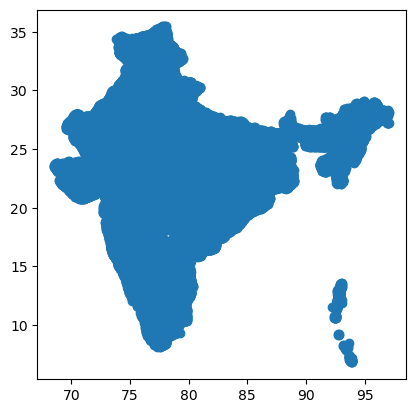

In [7]:
points_gdf.plot()

## Get the imagery around each point

Convert to dask geodataframe

In [9]:
NPARTITIONS = 250
points_dgdf = dask_gpd.from_geopandas(points_gdf, npartitions=NPARTITIONS, sort=False)

del points_gdf
gc.collect()

133

In [10]:
client = Client(n_workers=16)
print(client.dashboard_link)

# `meta` is the expected output format:
# an empty df with correct column types
meta = points_dgdf._meta
meta = meta.assign(stac_item=pd.Series([], dtype="object"))

points_gdf_with_stac = points_dgdf.map_partitions(
    fetch_least_cloudy_stac_items, 
    satellite="landsat-8-c2-l2",
    search_start="2013-01-01",
    search_end="2013-12-31",
    meta=meta)

points_gdf_with_stac = points_gdf_with_stac.compute()

client.close()

/user/amirali1376@gmail.com/proxy/8787/status


2022-12-01 04:15:44,704 - distributed.nanny - WARNING - Worker process still alive after 3.9999990463256836 seconds, killing
2022-12-01 04:15:44,705 - distributed.nanny - WARNING - Worker process still alive after 3.9999996185302735 seconds, killing
2022-12-01 04:15:44,706 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
2022-12-01 04:15:44,710 - distributed.nanny - WARNING - Worker process still alive after 3.9999994277954105 seconds, killing
2022-12-01 04:15:44,712 - distributed.nanny - WARNING - Worker process still alive after 3.9999994277954105 seconds, killing
2022-12-01 04:15:44,713 - distributed.nanny - WARNING - Worker process still alive after 3.9999994277954105 seconds, killing
2022-12-01 04:15:44,714 - distributed.nanny - WARNING - Worker process still alive after 3.999999237060547 seconds, killing
2022-12-01 04:15:44,715 - distributed.nanny - WARNING - Worker process still alive after 3.9999994277954105 seconds, killing
20

In [11]:
points_gdf_with_stac_clean = points_gdf_with_stac.dropna(subset=["stac_item"])
matched_stac_items = points_gdf_with_stac_clean.stac_item.tolist()
matched_points_list = points_gdf_with_stac_clean[["lon", "lat"]].to_numpy()

In [12]:
BUFFER_DISTANCE = 0.005
bands = [
    # "SR_B1", # Coastal/Aerosol Band (B1)
    "SR_B2",  # Blue Band (B2)
    "SR_B3",  # Green Band (B3)
    "SR_B4",  # Red Band (B4)
    "SR_B5",  # Near Infrared Band 0.8 (B5)
    "SR_B6",  # Short-wave Infrared Band 1.6 (B6)
    "SR_B7",  # Short-wave Infrared Band 2.2 (B7)
]
resolution = 30

dataset = CustomDataset(
    matched_points_list, 
    matched_stac_items, 
    buffer=BUFFER_DISTANCE,
    bands=bands,
    resolution=resolution
)

In [13]:
batch_size = 1

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(),
    collate_fn=lambda x: x,
    pin_memory=False,
    # persistent_workers=True,
)

In [14]:
# for images in dataloader:
#     for image in images:
#         array = np.array(image[0][:3])
#         reshaped_array = np.swapaxes(array, 0, 2)
#         plt.imshow(reshaped_array)
#         plt.show()

## Define featurization model and apply to images

First we define the pytorch model that we will use to extract the features and a helper method. The **MOSAIKS** methodology describes several ways to do this and we use the simplest.

Next, we initialize the model and pytorch components

In [15]:
num_features = 1024

In [16]:
DEVICE = torch.device("cuda")
MODEL = RCF(num_features).eval().to(DEVICE)

### Apply featurization to images

In [17]:
min_image_edge = 6

In [ ]:
num_points = len(matched_points_list)
x_all = np.zeros((num_points, num_features), dtype=float)

tic = time.time()
i = 0
for images in tqdm(dataloader):
    for image in images:

        if image is not None:
            # A full image should be ~101x101 pixels (i.e. ~1km^2 at a 10m/px spatial
            # resolution), however we can receive smaller images if an input point
            # happens to be at the edge of a S2 scene (a literal edge case). To deal
            # with these (edge) cases we crudely drop all images where the spatial
            # dimensions aren't both greater than 20 pixels.
            if image.shape[2] >= min_image_edge and image.shape[3] >= min_image_edge:
                mosaiks_features = featurize(image, MODEL, DEVICE)
                x_all[i] = mosaiks_features
            else:
                # this happens if the point is close to the edge of a scene
                # (one or both of the spatial dimensions of the image are very small)
                pass
        else:
            pass  # this happens if we do not find an image for some point

  0%|          | 0/94392 [00:00<?, ?it/s]

In [ ]:
x_all.shape

In [ ]:
np.savetxt("x_all_2013.csv", x_all, delimiter=",")